In [ ]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.ticker as mtick

from collections import Counter



In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/arpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = "topic"
tag = ""

In [4]:
# Open data
df = pd.read_csv(f"../data/df_shuffled_{dataset}{tag}.csv") # not shared, contact the authors for access
df["text"] = df["body"]
df = df[["id", "text", "dataset"]]

In [5]:
df2 = pd.read_csv(f"../data/df_irontfrontusa_sub.csv") # not shared, contact the authors for access
df2["dataset"] = "irontfrontusa"
df2 = df2[["id", "text", "dataset"]]

In [6]:
df = pd.concat([df, df2])
# shuffle
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

In [7]:
df["dataset"].value_counts()

vaccine          679
gamestop         200
irontfrontusa    192
Name: dataset, dtype: int64

In [8]:
# load nltk stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)
df["body_clean"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

{'doesn', 'wouldn', 'some', 'ain', 'haven', "they're", "they'd", "you'll", 'from', 'itself', "doesn't", 'the', "it'd", 'there', 'has', 'my', 've', 'me', "she'll", 'they', 'which', 'herself', 'against', 'didn', 'is', "don't", 'only', 'hers', 'weren', 'having', "i'm", 'now', 'most', 'will', 'been', 'mightn', "we're", 'isn', "they'll", 't', 'll', 'him', "shan't", "i'll", 'himself', 'o', 'all', 'don', 'theirs', 'had', 'once', 'and', 'ours', "hadn't", 'that', 'same', 'our', 'so', "shouldn't", 'through', 'nor', "mightn't", "he'll", 'just', 'needn', 'because', "she'd", 'down', 'them', 'it', 'again', 'more', 'below', "i've", 'on', 'couldn', 'doing', 'her', 'during', 'shan', 'then', 'by', "mustn't", 'does', "you're", 'no', 'this', 'each', "she's", 'we', 'above', 'after', "wouldn't", 'his', 'she', 'until', 'you', 'yourself', 'being', 'its', 'ourselves', 'a', 'why', "weren't", 'won', "should've", 'as', 'under', 'your', 'have', 'be', 'these', 'i', 'an', 'at', 'over', 'when', 'd', 'for', "you'd", '

In [9]:
cnt = Counter()
for text in df["body_clean"].values:
    for word in text.split():
        cnt[word] += 1

FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])

def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["body_clean"] = df["body_clean"].apply(lambda text: remove_freqwords(text))

df["body_clean"].head()

# remove deleted posts
df = df[df["body_clean"]!="[deleted]"]
df = df[df["body_clean"]!="[removed]"]

In [10]:
df["dataset"].value_counts()

vaccine          679
gamestop         200
irontfrontusa    180
Name: dataset, dtype: int64

# Action scores vs. topic modeling of topical data

In [11]:
# defone umap model and fix seed
umap_model = UMAP(random_state=100)
model = BERTopic(language="english", umap_model=umap_model)
topics, _ = model.fit_transform(df['body_clean'])

In [12]:
## print the topics
print(model.get_topic_info())

   Topic  Count                                Name  \
0     -1    253           -1_gene_therapy_say_thats   
1      0    328        0_covid_effects_risk_vaccine   
2      1    164       1_voting_vote_democrats_power   
3      2    105         2_intj_argument_briggs_shit   
4      3     98           3_robinhood_money_gme_app   
5      4     33  4_science_research_scientific_time   
6      5     25                5_twist_dick_it_lets   
7      6     23                  6_this_baaaa_fr_ty   
8      7     16                7_yes_no_sure_thisll   
9      8     14        8_booster_soon_yes_yesterday   

                                      Representation  \
0  [gene, therapy, say, thats, yes, bs, internet,...   
1  [covid, effects, risk, vaccine, vaccinated, si...   
2  [voting, vote, democrats, power, party, fuckin...   
3  [intj, argument, briggs, shit, read, myers, ca...   
4  [robinhood, money, gme, app, shares, transfer,...   
5  [science, research, scientific, time, scientis...   
6 

In [13]:
topic_labels = model.generate_topic_labels()

Topical distance

In [ ]:
topic_embeddings = model.topic_embeddings_	

# find distances (cosine similarity) between topics
distances = cosine_similarity(topic_embeddings)

# table of distances
df_distances = pd.DataFrame(distances, columns=topic_labels, index=topic_labels)
df_distances

,-1_gene_therapy_say,0_covid_effects_risk,1_voting_vote_democrats,2_intj_argument_briggs,3_robinhood_money_gme,4_science_research_scientific,5_twist_dick_it,6_this_baaaa_fr,7_yes_no_sure,8_booster_soon_yes
-1_gene_therapy_say,1.000000,0.554889,0.556746,0.774797,0.528361,0.601941,0.583878,0.608139,0.666329,0.489419
0_covid_effects_risk,0.554889,1.000000,0.362240,0.449462,0.257217,0.462662,0.171321,0.193294,0.296070,0.494177
1_voting_vote_democrats,0.556746,0.362240,1.000000,0.600411,0.239715,0.404432,0.304703,0.232511,0.324354,0.228941
2_intj_argument_briggs,0.774797,0.449462,0.600411,1.000000,0.324982,0.601874,0.341537,0.377300,0.458033,0.281038
3_robinhood_money_gme,0.528361,0.257217,0.239715,0.324982,1.000000,0.250154,0.359304,0.360133,0.342344,0.249617
4_science_research_scientific,0.601941,0.462662,0.404432,0.601874,0.250154,1.000000,0.225399,0.222538,0.305495,0.247456
5_twist_dick_it,0.583878,0.171321,0.304703,0.341537,0.359304,0.225399,1.000000,0.488587,0.390866,0.261483
6_this_baaaa_fr,0.608139,0.193294,0.232511,0.377300,0.360133,0.222538,0.488587,1.000000,0.628478,0.303917
7_yes_no_sure,0.666329,0.296070,0.324354,0.458033,0.342344,0.305495,0.390866,0.628478,1.000000,0.344443
8_booster_soon_yes,0.489419,0.494177,0.228941,0.281038,0.249617,0.247456,0.261483,0.303917,0.344443,1.000000


Visualize topics

## Look at UMAP

In [15]:
df = df.reset_index(drop=True)

In [16]:
# use sentence transformer 'all-MiniLM-L6-v2' to embed the "body_clean" text
emb_model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = emb_model.encode(df['body_clean'], show_progress_bar=True)

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [17]:
# umap to reduce the dimensionality of the embeddings
umap_embeddings = UMAP(n_components=2,metric='cosine',random_state=100).fit_transform(embeddings)

In [18]:
df["umap_topic_1"] = umap_embeddings[:, 0]
df["umap_topic_2"] = umap_embeddings[:, 1]
df["topic"] = topics

['0', '1', '2', '3']


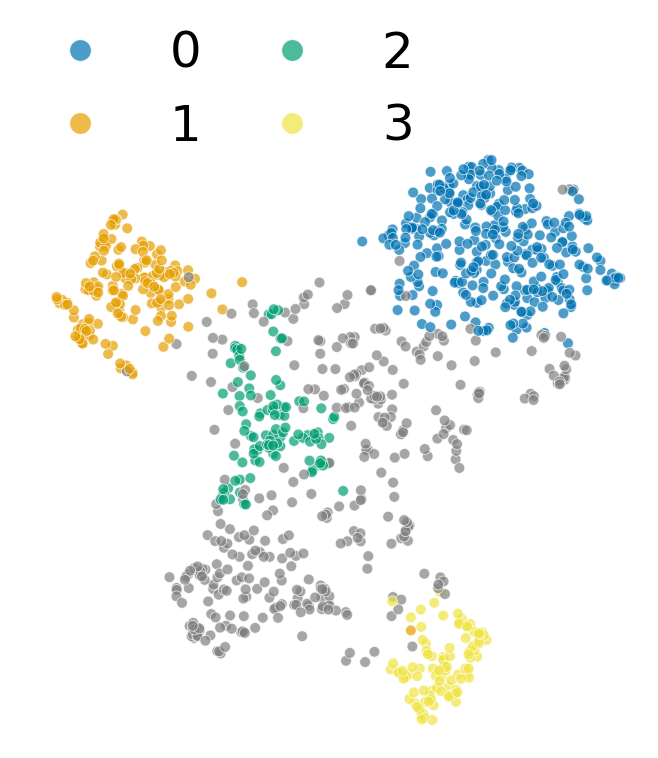

In [19]:
# figure size
plt.figure(figsize=(8, 8))

dictionary_colors = {-1: "grey", 0: "#0072B2", 1: "#E69F00", 2: "#009E73",
                     3: "#F0E442", 4: "grey", 5: "grey", 6: "grey",
                     7: "grey", 8: "grey", 9: "grey"}


# scatterplot of umap embeddings
sns.scatterplot(
    data=df, 
    x="umap_topic_1",
    y="umap_topic_2",
    hue="topic",
    s=60,
    alpha=0.7,
    palette=dictionary_colors
)

# remove axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# remove -1 from legend and adjust
handles, labels = plt.gca().get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0])))
labels = [label for label in labels if label not in ["-1", "4", "5", "6", "7", "8"]]
print(labels)
# fix handles according to labels
handles = handles[1:]
plt.legend(handles, labels,
    fontsize=36,         # Adjust font size
    bbox_to_anchor=(-0.07, 1.24),  # Move outside to the right
    markerscale=2,       # Increase marker size
    loc='upper left',   # Place legend inside the plot
    ncol=2,               # Single-column legend
    framealpha = 0.0,    # No border
    columnspacing=0.8)

# remove box around legend
plt.gca().get_legend().get_frame().set_linewidth(0.0)

# save as PNG
plt.savefig(f"./plots/umap_topics_v2.png", dpi=300, bbox_inches='tight')

# plt.show()

['0', '1', '2', '3', '4', '5', '6', '7', '8']


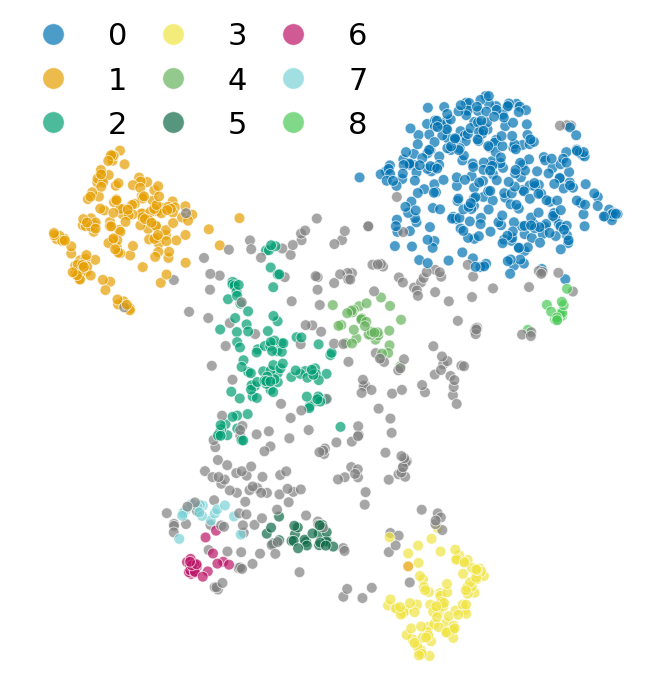

In [20]:
# figure size
plt.figure(figsize=(8, 8))

dictionary_colors = {-1: "grey", 0: "#0072B2", 1: "#E69F00", 2: "#009E73",
                     3: "#F0E442", 4: "#66b35c", 5: "#0e6a47", 6: "#bc1466",
                     7: "#79d2d6", 8: "#4aca57"}


# scatterplot of umap embeddings
sns.scatterplot(
    data=df, 
    x="umap_topic_1",
    y="umap_topic_2",
    hue="topic",
    s=60,
    alpha=0.7,
    palette=dictionary_colors
)

# remove axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# remove -1 from legend and adjust
handles, labels = plt.gca().get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0])))
labels = [label for label in labels if label not in ["-1"]]
print(labels)
# fix handles according to labels
handles = handles[1:]
plt.legend(handles, labels,
    fontsize=22,         # Adjust font size
    bbox_to_anchor=(-0.05, 1.12),  # Move outside to the right
    markerscale=2,       # Increase marker size
    loc='upper left',   # Place legend inside the plot
    ncol=3,               # Single-column legend
    framealpha = 0.0,    # No border
    columnspacing=0.5)

# remove box around legend
plt.gca().get_legend().get_frame().set_linewidth(0.0)

# save as PNG
plt.savefig(f"./plots/umap_topics_full_v2.png", bbox_inches='tight')

In [21]:
df["dataset"] = df["dataset"].str.replace("vaccine", "intj")
df["dataset"] = df["dataset"].str.replace("gamestop", "wallstreetbets")

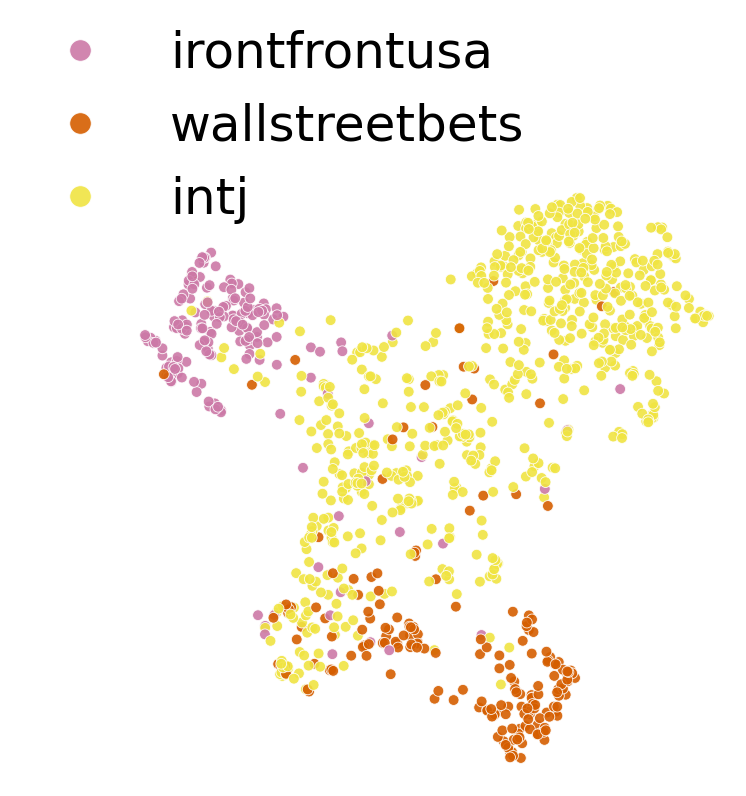

In [22]:
# figure size
plt.figure(figsize=(8, 8))

# Updated palette for better contrast
palette = ["#CC79A7", "#D55E00", "#F0E442"]  # Purple, Yellow, Red

# Scatterplot of UMAP embeddings with colors corresponding to the datasets
sns.scatterplot(
    data=df,
    x="umap_topic_1",
    y="umap_topic_2",
    hue="dataset",      # Assuming 'dataset' column contains categories to differentiate
    s=60,               # Slightly larger markers for visibility
    alpha=0.9,          # Adjusted transparency
    palette=palette     # Updated color palette
)

# Remove axis for cleaner look
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# Remove spines for a minimalistic look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Adjust legend placement and style
plt.legend(
    fontsize=36,         # Adjust font size for readability
    bbox_to_anchor=(0.73, 0.84),  # Move outside to the right
    markerscale=2,       # Increase marker size in the legend
    ncol=1,               # Single-column legend for clarity
    framealpha=0.0       # Remove legend box
)

# Remove box around the legend
plt.gca().get_legend().get_frame().set_linewidth(0.0)

# Save the figure with high DPI
plt.savefig(f"./plots/umap_datasets_v2.png", bbox_inches='tight')

# Compare with our classification

Open inference results on topic model data

In [23]:
data1 = pd.read_csv("./classifier/predictions/predictions_roberta_simplified_synthetic_weights_topic_ironfrontusa.csv")

In [24]:
data2 = pd.read_csv("./classifier/predictions/predictions_roberta_simplified_synthetic_weights_topic.csv")

In [25]:
data2["dataset"].value_counts()

vaccine     679
gamestop    200
Name: dataset, dtype: int64

In [26]:
df["dataset"].value_counts()

intj              679
wallstreetbets    200
irontfrontusa     180
Name: dataset, dtype: int64

In [27]:
data = pd.concat([data1, data2])

In [28]:
df.columns, data.columns

(Index(['id', 'text', 'dataset', 'body_clean', 'umap_topic_1', 'umap_topic_2',
        'topic'],
       dtype='object'),
 Index(['id', 'subreddit', 'link_id', 'parent_id', 'created_at', 'author',
        'text', 'predictions', 'class_probabilities', 'date', 'body',
        'dataset'],
       dtype='object'))

In [29]:
# get "dataset" from df
data = data.merge(df[["text", "id", "dataset", "umap_topic_1", "umap_topic_2"]], on="text")

In [30]:
data["classification_action"] = ["Participation\nin collective\naction" if x == 0 else "None" for x in data["predictions"]]

In [31]:
data.columns

Index(['id_x', 'subreddit', 'link_id', 'parent_id', 'created_at', 'author',
       'text', 'predictions', 'class_probabilities', 'date', 'body',
       'dataset_x', 'id_y', 'dataset_y', 'umap_topic_1', 'umap_topic_2',
       'classification_action'],
      dtype='object')

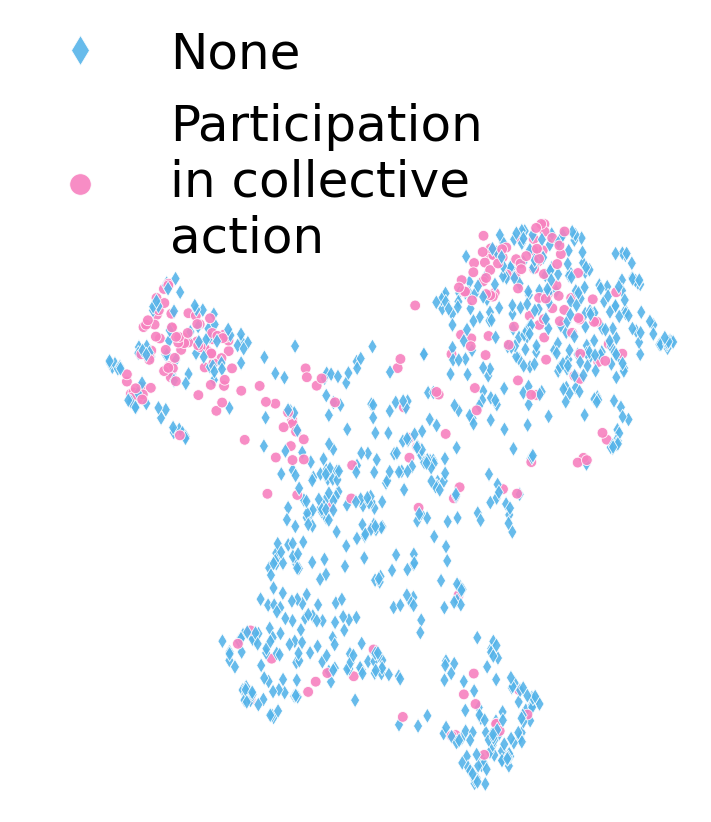

In [32]:
# figure size
plt.figure(figsize=(8, 8))

# scatterplot of umap embeddings, with colors corresponding to the topics (and shapes corresponding to the datasets
# use "color" and "marker" columns to color and shape the points
palette = ["#56B4E9", "#F781BF"]

sns.scatterplot(data=data, x="umap_topic_1", y="umap_topic_2", hue="classification_action", s=60, alpha=0.9, 
                style="classification_action", palette=palette, markers={"Participation\nin collective\naction": "o", "None": "d"},)

# remove axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# increase font size of legend
plt.legend(
    fontsize=36,         # Adjust font size for readability
    bbox_to_anchor=(0.72, 0.82),  # Move outside to the right
    markerscale=2,       # Increase marker size in the legend
    ncol=1,               # Single-column legend for clarity
    framealpha=0.0
)

# remove box around legend
plt.gca().get_legend().get_frame().set_linewidth(0.0)

# save as png
plt.savefig(f"./plots/umap_commitment_v2.png", bbox_inches='tight')


# Topic modeling applied on our test data

In [ ]:
data = pd.read_csv("../data/test_set.csv")

# change "Non-action" to "None" in the simplified_label column
data["simplified_label"] = ["None" if x=="None" else "Action" for x in data["annotation"]]

data["text"] = data["ActionFocusedText"]

df_test = data.copy()

In [91]:
# load nltk stopwords
stop_words = set(stopwords.words('english'))
df_test["text_clean"] = df_test["text"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
# eliminate words that are too frequent
from collections import Counter

cnt = Counter()
for text in df_test["text_clean"].values:
    for word in text.split():
        cnt[word] += 1

FREQWORDS = set([w for (w, wc) in cnt.most_common(30)])

def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df_test["text_clean"] = df_test["text_clean"].apply(lambda text: remove_freqwords(text))

In [92]:
# defone umap model and fix seed
umap_model = UMAP(random_state=100)
model = BERTopic(language="english", umap_model=umap_model)
topics, _ = model.fit_transform(df_test['text_clean'])

In [93]:
## print the topics
print(model.get_topic_info())

    Topic  Count                                           Name  \
0      -1    284                       -1_us_thats_something_do   
1       0    180                       0_us_right_fight_protest   
2       1     48                           1_im_strike_its_32we   
3       2     36                        2_school_kids_job_class   
4       3     36                  3_animal_animals_vegan_rights   
5       4     31                    4_israel_jews_israeli_peace   
6       5     27                  5_water_energy_plants_problem   
7       6     25                     6_russia_war_regime_rebels   
8       7     22                 7_meds_release_dex_compromised   
9       8     21            8_dyslexia_processing_muscle_issues   
10      9     20               9_candidate_election_voters_2018   
11     10     19                       10_men_rape_woman_womens   
12     11     19            11_feminist_feminists_feminism_mens   
13     12     17                        12_hsv_virus_pcr_herpe

In [94]:
topic_labels = model.generate_topic_labels()

In [95]:
# assign topic labels to the test data
df_test["topic"] = topics

df_test["topic_name"] = df_test["topic"].apply(lambda x: topic_labels[x])

Topical distance

In [ ]:
topic_embeddings = model.topic_embeddings_	

# find distances (cosine similarity) between topics
distances = cosine_similarity(topic_embeddings)

# table of distances
df_distances = pd.DataFrame(distances, columns=topic_labels, index=topic_labels)
df_distances

,-1_us_thats_something,0_us_right_fight,1_im_strike_its,2_school_kids_job,3_animal_animals_vegan,4_israel_jews_israeli,5_water_energy_plants,6_russia_war_regime,7_meds_release_dex,8_dyslexia_processing_muscle,9_candidate_election_voters,10_men_rape_woman,11_feminist_feminists_feminism,12_hsv_virus_pcr,13_white_french_imperative,14_circumcision_frenulum_circumcised
-1_us_thats_something,1.000000,0.918243,0.751218,0.533552,0.578548,0.530311,0.532116,0.520772,0.483645,0.378923,0.569491,0.643742,0.651626,0.438642,0.567834,0.432023
0_us_right_fight,0.918243,1.000000,0.662937,0.407148,0.561083,0.547702,0.458780,0.531665,0.396189,0.282657,0.540717,0.568711,0.634360,0.359118,0.541265,0.305087
1_im_strike_its,0.751218,0.662937,1.000000,0.473196,0.351775,0.344905,0.432359,0.461734,0.333712,0.287941,0.427708,0.412260,0.410138,0.327990,0.328688,0.246538
2_school_kids_job,0.533552,0.407148,0.473196,1.000000,0.234203,0.126732,0.329903,0.149134,0.408489,0.413268,0.199339,0.295935,0.213089,0.208613,0.179652,0.127793
3_animal_animals_vegan,0.578548,0.561083,0.351775,0.234203,1.000000,0.334258,0.417102,0.232014,0.236064,0.159988,0.251109,0.344447,0.475468,0.330879,0.357511,0.293477
4_israel_jews_israeli,0.530311,0.547702,0.344905,0.126732,0.334258,1.000000,0.220703,0.557696,0.167592,0.120352,0.245696,0.383000,0.355856,0.202405,0.483144,0.187639
5_water_energy_plants,0.532116,0.458780,0.432359,0.329903,0.417102,0.220703,1.000000,0.206967,0.233506,0.130637,0.351238,0.191246,0.238066,0.272087,0.173275,0.187008
6_russia_war_regime,0.520772,0.531665,0.461734,0.149134,0.232014,0.557696,0.206967,1.000000,0.196912,0.061459,0.329039,0.298954,0.291085,0.239150,0.327982,0.092697
7_meds_release_dex,0.483645,0.396189,0.333712,0.408489,0.236064,0.167592,0.233506,0.196912,1.000000,0.561291,0.165943,0.311131,0.208069,0.361836,0.163956,0.201704
8_dyslexia_processing_muscle,0.378923,0.282657,0.287941,0.413268,0.159988,0.120352,0.130637,0.061459,0.561291,1.000000,0.155237,0.207328,0.141777,0.310692,0.150118,0.226209


Visualize topics

## Look at UMAP

In [97]:
# use sentence transformer 'all-MiniLM-L6-v2' to embed the "body_clean" text
emb_model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = emb_model.encode(df_test['text_clean'].to_list(), show_progress_bar=True)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

In [98]:
# umap to reduce the dimensionality of the embeddings
umap_embeddings = UMAP(n_components=2,metric='cosine',random_state=100).fit_transform(embeddings)

In [99]:
df_test["umap_topic_1"] = umap_embeddings[:, 0]
df_test["umap_topic_2"] = umap_embeddings[:, 1]

df_test["topic"] = topics

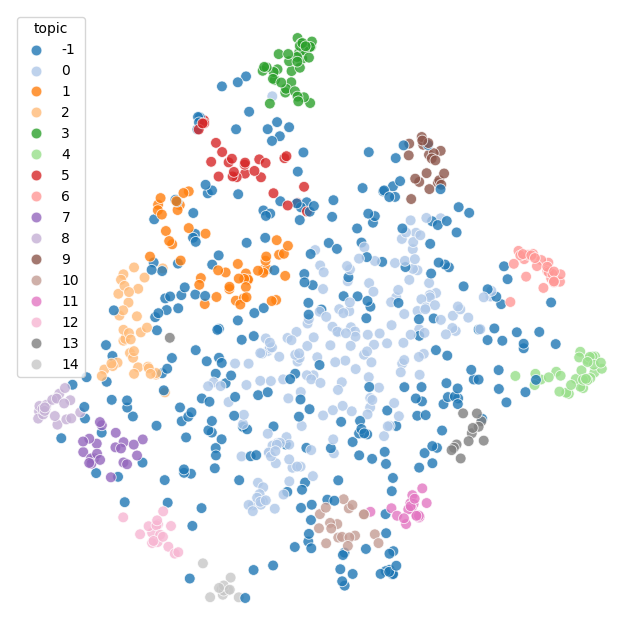

In [ ]:
# figure size
plt.figure(figsize=(8, 8))

# scatterplot of umap embeddings, with colors corresponding to the topics (and shapes corresponding to the datasets
# use "color" and "marker" columns to color and shape the points
sns.scatterplot(data=df_test, x="umap_topic_1", y="umap_topic_2", hue="topic", s=60, alpha=0.8, palette="tab20")

# remove axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.show()


# Compare with our classification

Open inference results on topic model data

In [ ]:
data = pd.read_csv("../data/predictions/predictions_roberta_simplified_synthetic_weights.csv")

In [103]:
df_test["classification_action"] = ["Committed to collective action" if x == 0 else "Non-committed" for x in data["predictions"]]

In [104]:
# table topic vs classification_action
table = pd.crosstab(df_test["topic_name"], df_test["classification_action"], normalize="index")
table

classification_action,Committed to collective action,Non-committed
topic_name,,
-1_us_thats_something,0.411111,0.588889
0_us_right_fight,0.312500,0.687500
10_men_rape_woman,0.473684,0.526316
11_feminist_feminists_feminism,0.176471,0.823529
12_hsv_virus_pcr,0.384615,0.615385
13_white_french_imperative,0.272727,0.727273
14_circumcision_frenulum_circumcised,0.366197,0.633803
1_im_strike_its,0.250000,0.750000
2_school_kids_job,0.472222,0.527778


In [105]:
# remove index
table.reset_index(inplace=True)

In [106]:
table

classification_action,topic_name,Committed to collective action,Non-committed
0,-1_us_thats_something,0.411111,0.588889
1,0_us_right_fight,0.312500,0.687500
2,10_men_rape_woman,0.473684,0.526316
3,11_feminist_feminists_feminism,0.176471,0.823529
4,12_hsv_virus_pcr,0.384615,0.615385
5,13_white_french_imperative,0.272727,0.727273
6,14_circumcision_frenulum_circumcised,0.366197,0.633803
7,1_im_strike_its,0.250000,0.750000
8,2_school_kids_job,0.472222,0.527778
9,3_animal_animals_vegan,0.354839,0.645161


In [107]:
df = table.copy()

In [108]:
# remove topic starting with -1
df = df[df["topic_name"].str.startswith("-1")==False]

In [109]:
# rename topics

dict_names = {"0_us_right_fight": "us fight",
              "10_men_rape_woman": "man and rape",
              "11_feminist_feminists_feminism": "feminism",
              "12_hsv_virus_pcr": "hsv virus",
              "13_white_french_imperative": "white rights",
              "14_circumcision_frenulum_circumcised": "circumcision",
              "2_animal_animals_vegan": "animal protection",
              "1_im_strike_its": "strike",
              "2_school_kids_job": "school",
              "3_animal_animals_vegan": "animal rights",
              "4_israel_jews_israeli": "israel",
              "5_water_energy_plants": "green energy",
              "6_russia_war_regime": "russia",
              "7_meds_release_dex": "medicines",
              "8_dyslexia_processing_muscle": "dislexia",
              "9_candidate_election_voters": "elections",}

In [110]:
df["topic_name"] = df["topic_name"].replace(dict_names)

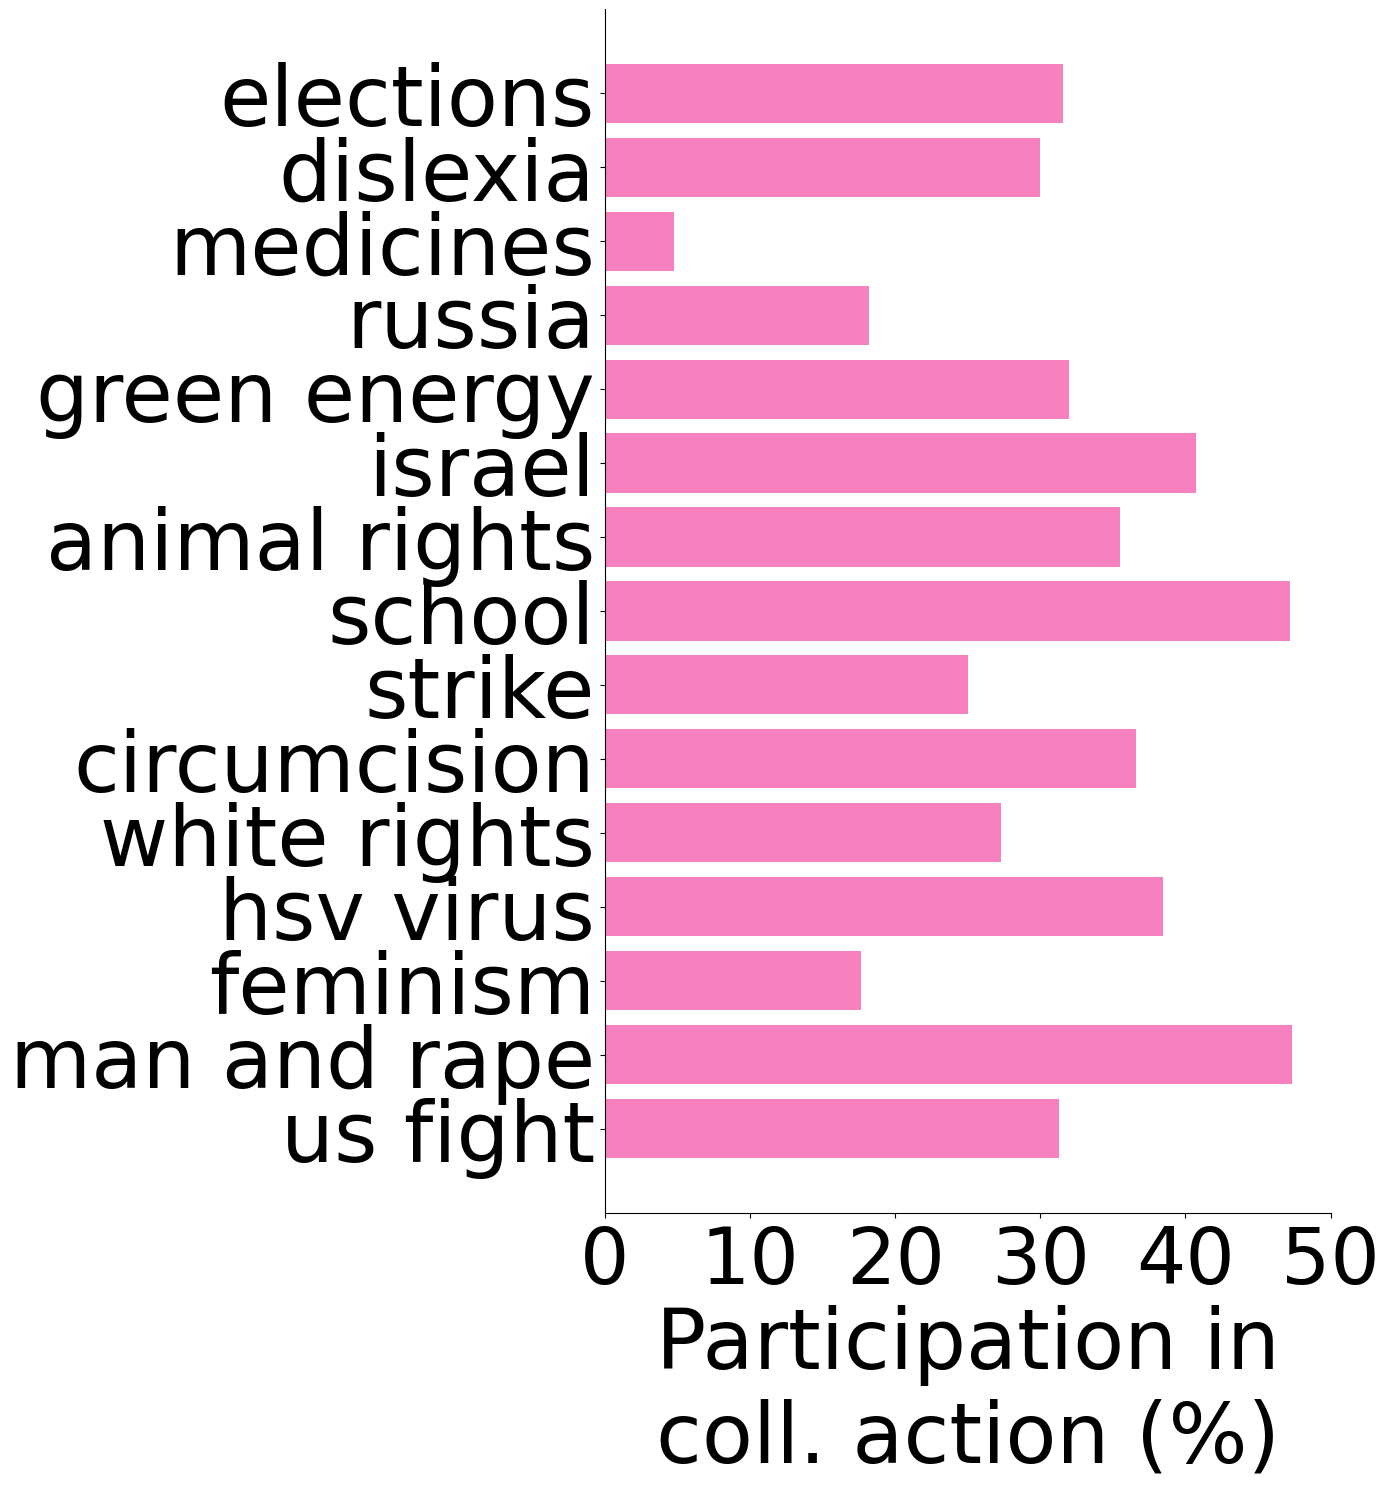

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(14, 15))

# Stacked horizontal bar chart
ax.barh(df['topic_name'], df['Committed to collective action']*100, label='Committed', color='#F781BF')
# ax.barh(df['topic_name'], df['Non-committed']*100, left=df['Committed to collective action']*100, label='Non-committed', color='grey')

# Add labels and title
ax.set_xlabel('Participation in\ncoll. action (%)', fontsize=60)
# x ticks, show as int and not as float
ax.set_yticklabels(df['topic_name'])

# Show the plot
plt.tight_layout()

# adjust the size of the ticks
plt.yticks(fontsize=60)

# Set x-ticks as integers
max_val = (df['Committed to collective action'] * 100).max()
xticks = np.arange(0, int(max_val) + 10, 10)
ax.set_xticks(xticks)

plt.xticks(fontsize=56)

# Remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout to fit everything
plt.tight_layout()

plt.show()
